In [1]:
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import pandas as pd

import cobra
#import escher
 
%matplotlib inline

<h3> Loading the Ecoli models <h3>

In [2]:
from genericpath import isfile
import os

dir = 'data'
models = []

for filename in os.scandir(dir):
    f = os.path.join(filename)
    if filename.is_file():
        print(filename.name)
        models.append(cobra.io.read_sbml_model(f))
    
#cobra.io.read_sbml_model("./data/iEC1344_C.xml")
#model = cobra.io.load_model("textbook") 
# for i in models[0].reactions:
#     print(i)

iEcHS_1320.xml
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
iEC1344_C.xml
iEcDH1_1363.xml
iECS88_1305.xml
iECW_1372.xml


<h2> BiGG Model to Networkx Graph

In [145]:
tmodel = cobra.io.load_model('e_coli_core')
tmodel.optimize()

,fluxes,reduced_costs
PFK,7.477382,-1.387779e-17
PFL,0.000000,2.081668e-17
PGI,4.860861,0.000000e+00
PGK,-16.023526,6.938894e-18
PGL,4.959985,1.517883e-17
...,...,...
NADH16,38.534610,0.000000e+00
NADTRHD,0.000000,-2.546243e-03
NH4t,4.765319,-1.387779e-17
O2t,21.799493,0.000000e+00


In [146]:
#pfk = tmodel.reactions.get_by_id('P3HB')
#pfk.flux

In [147]:
rxns = {}#[]
mbls = set()#[]

"""TO DO:
- Add fluxes, aka weighted edges for metabolites: Stoichemetric, how many of each does it take/produce. Always an integer.
- Fix node font size
- Do with actual model not just ecoli_core
"""

for rxn in tmodel.reactions: 
    #rxns.add(rxn.id)
    #print(rxn)
    #add reactants
    reactants_list = []
    for i in rxn.reactants:
        reactants_list.append(i.id)
  #  print(reactants_list)
    products_list = []
    for i in rxn.products:
        products_list.append(i.id)
            
    rxns[rxn.id] = reactants_list, products_list

for mbl in tmodel.metabolites: mbls.add(mbl.id)#, print(mbl)
   
print(len(rxns))
#display(rxns)
print(len(mbls))
#display(mbls)


95
72


In [148]:
B = nx.DiGraph()
B.add_nodes_from(mbls, bipartite=1,)
B.add_nodes_from(rxns, bipartite=1)

In [149]:
"""Add edges for substrate, products to/out reactions"""
for name in rxns:
    subs, prods = rxns[name]
    for sub in subs:
        #print(sub)
        #ADD AN EDGE FROM SUBSTRATE TO REACTION. Where left hand side is metabolites and right is reactions
        B.add_edge(sub, name)
        
    for prod in prods:
        #ADD AN EDGE FROM REACTION TO PRODUCTS
        B.add_edge(name, prod)
        
    #B.add_edge()

#print(rxns)
#B.add_edge('PFK', '2pg_c')

<H3>Get interesting paths (highest degree, shortest, longest, biomass related) </h3>

In [150]:
#Select highest degree node in reactions and get path
#tmodel.reactions.get_by_id("BIOMASS_Ecoli_core_w_GAM")
max_degree = ('', 0)
for i in B.degree():
    if(i[0] in mbls):
    #print(i[0])
        if i[1] > max_degree[1]:
            max_degree = i
print(max_degree)

biomass_path = B.in_edges('BIOMASS_Ecoli_core_w_GAM')
#path_edges = list(zip(biomass_path,biomass_path[1:]))
short_path = nx.shortest_path(B, source='glu__L_c', target='nadp_c')

print(short_path)
#biomass_path.append(B.out_edges('BIOMASS_Ecoli_core_w_GAM'))
#print(short_path)

#
tmodel.reactions.get_by_id('BIOMASS_Ecoli_core_w_GAM').flux

paths = nx.all_simple_paths(B, 'h_c', 'atp_c', cutoff=12)
longest_path = []
for i in paths:
    if len(i) > len(longest_path):
        longest_path = i
    #
print(longest_path)

('h_c', 35)
['glu__L_c', 'BIOMASS_Ecoli_core_w_GAM', 'nadp_c']
['h_c', 'PYK', 'pyr_c', 'PFL', 'accoa_c', 'PTAr', 'coa_c', 'ACALD', 'nadh_c', 'NADH16', 'h_e', 'ATPS4r', 'atp_c']


Shortest Path Using Manual Knockout

In [151]:
B.nodes['BIOMASS_Ecoli_core_w_GAM']
G = B.copy()
G.remove_node("BIOMASS_Ecoli_core_w_GAM") #Important to remove this otherwise just jumps through Pseudoreaction. 
G.remove_node("G6PDH2r")
G.remove_node("pyr_c")


paths = nx.all_shortest_paths(G, "glc__D_e", "nadp_c" )

for i in paths:
    print(i)
    #

['glc__D_e', 'GLCpts', 'g6p_c', 'PGI', 'f6p_c', 'PFK', 'h_c', 'GLUSy', 'nadp_c']


In [157]:
def draw_bipartite(G,z, first_partition, input_path, node_flag = False):
    # MODIFY THIS FUNCTION AS NEEDED
    # input  : G is a networkx graph
    #        : z is a dictionary of group labels for G's nodes
    # output : a circular layout plot (ignores edge weights)
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    colors = ['#d67711','#11d646','#1b11d6','#d611cc'] # map node labels to colors (for the visualization)

    node_colors = []
    for i in G.nodes():
        node_colors.append(colors[int(z[i])])
    nsize  = 500
    flabel = True

    if G.order() > 200:
        nsize  = 100
        flabel = False
        
    d = dict(G.degree)
    
    
    #pos = nx.draw_networkx(G,edge_color='teal',with_labels=flabel,node_size=nsize,width=2,node_color=node_colors,pos = nx.bipartite_layout(G, nodes=first_partition))#pos = nx.circular_layout(G)) # draw it pretty
    nx.draw(G,edge_color='teal',with_labels=flabel,node_size = [v * 100 for v in d.values()] if node_flag else nsize ,width=2,node_color= [v * 100 for v in d.values()] if node_flag else node_colors, pos = nx.bipartite_layout(G, nodes=first_partition))
    pos = nx.bipartite_layout(G, nodes=first_partition)
    path_edges = list(zip(input_path, input_path[1:]))
    #path_edges = input_path
    print(path_edges)
    nx.draw_networkx_edges(G, pos=pos, edgelist=path_edges, edge_color='purple',width=4)
    limits=plt.axis('off')                                      # turn off axes 
    plt.show() 

    return

In [158]:
#Z is dictionary of partitions
z = {}
for rxn in rxns:
    z[rxn] = 1
for met in mbls:
    z[met] = 0
#display(z)

[]


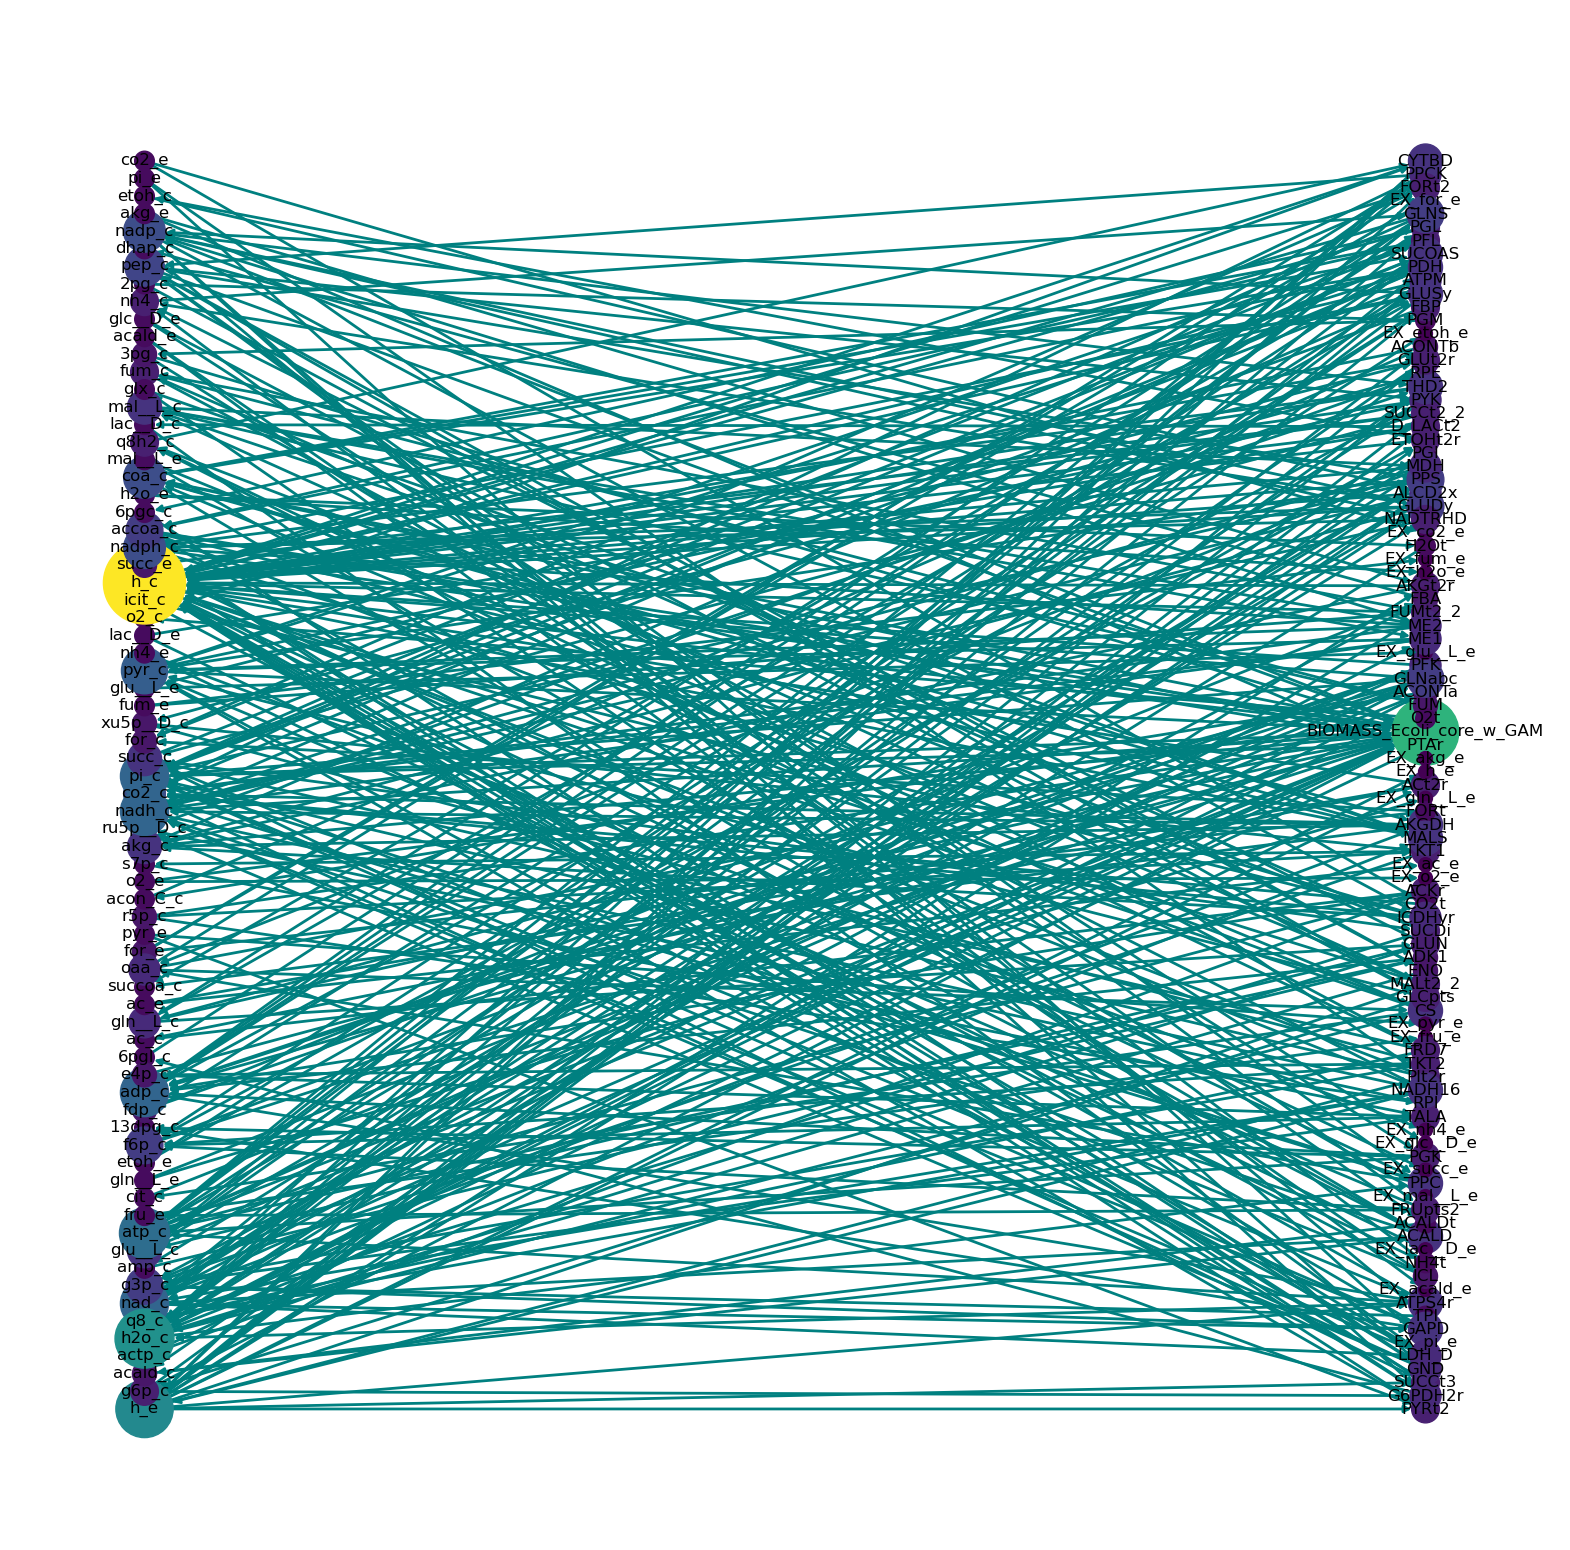

In [159]:
#nx.draw_networkx(B, width=1)
plt.figure(3,figsize=(20,20)) 
plt.title('E. Coli Core Metabolism, Orange nodes: metabolites, Green: reactions ', color='w')

#draw_bipartite(B, z, mbls, input_path=longest_path, node_flag=True)
draw_bipartite(B, z, mbls, input_path=[], node_flag=True)

plt.show()

Network Summary Statistics

clustering coefficient, C     =  0.00
Average Harmonic Centrality, C_2     =  4.31
max degree, k_max = 35
max degree, k_std =  4.01


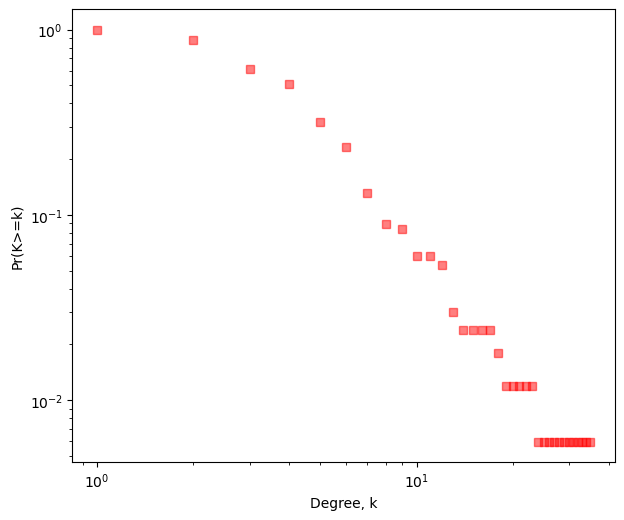

In [164]:
#diameter = nx.diameter(B) #max eccentricty from 1 node to furthest.
#Average shortest path
#ellmean = nx.average_shortest_path_length(B) 
#How clustered nodes are
C = nx.transitivity(B)
C_2 = nx.harmonic_centrality(B)
C_2_mean = np.mean([c for (n, c) in B.degree()])

#Calculates all connected components
#h = nx.number_connected_components(B)
all_degrees = [d for (n, d) in B.degree()]
kmax = max(all_degrees)
kstd = np.std(all_degrees)

##### do not modify below here #####
#print(f'diameter = {diameter}')
#print(f'mean geodesic distance, <ell> = %5.2f' % ellmean)
print(f'clustering coefficient, C     = %5.2f' % C)
print(f'Average Harmonic Centrality, C_2     = %5.2f' % C_2_mean)

#print(f'number of components,   h     =  {h}')
print(f'max degree, k_max = {kmax}')
print(f'max degree, k_std = %5.2f' % kstd)

def plot_CCDF(kis):
    # from PS5
    # input : a list of degrees, e.g., from a networkx graph G
    # output: a plot of the CCDF of the degree distribution Pr(K>=k) for k>=1
    
    kmax = max(kis)

    # histogram and plot
    counts, bins = np.histogram(kis, bins=[i for i in range(kmax+2)], density=True)
    cumcounts = np.cumsum(counts)
    cumcounts = np.insert(cumcounts,0,0)
    plt.loglog(bins[1:-1], 1-cumcounts[1:-1], 'rs', alpha=0.5)
    plt.xlabel('Degree, k')
    plt.ylabel('Pr(K>=k)')
    plt.show()
    return

plot_CCDF(all_degrees)

<h3> Reaction Knockout by Centrality/Clustering

In [144]:
#Rnx = B.subgraph(rxns)

#G = B.to_undirected()

#C = nx.transitivity(G)
#C

#C = nx.degree_centrality(B)

#C = nx.closeness_centrality(B)
#measures closeness. The more central a node is the more close it is to others. Measures the shortest
#distance to adjacent nodes.

C = nx.harmonic_centrality(B)
#C = nx.in_degree_centrality(B)
#C = nx.degree()
#Harmonic Centrality - average of reciprical distance
#Sort and Reverse
C = {k: v for k, v in sorted(C.items(), key=lambda item: item[1])}

#C = dict(reversed(list(C.items())))
C_list = []
C_scores = []
for str, func in C.items():
    if str in rxns:
       # print(str, func)
        C_list.append(str)
        C_scores.append(func)
        
C_list = []
C_scores = []
for (n, d) in B.degree():
    if n in rxns:
        C_list.append(n)
        C_scores.append(d)
        
    
#    C_list.append(n.degree)
        
        
#for i in C.values:
#    print(i)


KeyboardInterrupt: 

In [102]:
obj_vals = []
tmodel = cobra.io.load_model('e_coli_core')
tmodel.reactions.get_by_id("BIOMASS_Ecoli_core_w_GAM").objective_coefficient = 1.0
#tmodel.reactions.get_by_id("EX_glc__D_e").lower_bound = -10
#tmodel.reactions.get_by_id("EX_o2_e").lower_bound = -15    
#print(i)


sol_orig = tmodel.optimize().objective_value

for i in C_list:
    tmodel = cobra.io.load_model('e_coli_core')
    tmodel.reactions.get_by_id("BIOMASS_Ecoli_core_w_GAM").objective_coefficient = 1.0
    tmodel.reactions.get_by_id("EX_glc__D_e").lower_bound = -10
    tmodel.reactions.get_by_id("EX_o2_e").lower_bound = -15    
    #print(i)
    tmodel.reactions.get_by_id(i).knock_out()

    solution = tmodel.optimize()
    #print(solution.objective_value)
    delta = sol_orig - solution.objective_value
    obj_vals.append(delta)
#tmodel.reactions.GLUDy.flux


/home/gugu/mambaforge/envs/bioinfo/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/gugu/mambaforge/envs/bioinfo/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Text(0, 0.5, 'Objective Value')

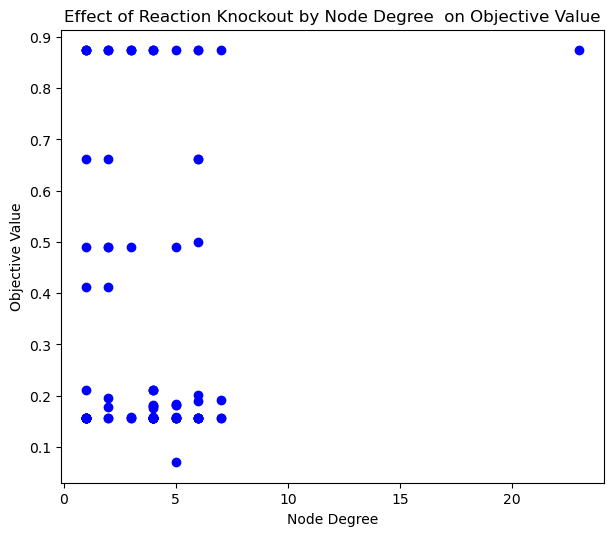

In [108]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams["figure.figsize"] = (7,6)
plt.scatter(C_scores, obj_vals, c='blue')
plt.title("Effect of Reaction Knockout by Node Degree  on Objective Value")
plt.xlabel("Node Degree")
plt.ylabel("Objective Value")

<H3> Reaction knock out </h3>

In [16]:
test = cobra.io.load_model('e_coli_core')
print(test)
for rxn in test.reactions:
    if rxn.id == 'PFK':
        print(rxn.id)
 
#print(test.reactions)
test.reactions[0]

#print(test.reactions)

e_coli_core
PFK


Reaction identifier,PFK
Name,Phosphofructokinase
Memory address,0x7fda0f16a770
Stoichiometry,"atp_c + f6p_c --> adp_c + fdp_c + h_c ATP C10H12N5O13P3 + D-Fructose 6-phosphate --> ADP C10H12N5O10P2 + D-Fructose 1,6-bisphosphate + H+"
GPR,b3916 or b1723
Lower bound,0.0
Upper bound,1000.0


In [17]:
for i in models:
    print(i.objective)

Maximize
1.0*BIOMASS_Ec_iJO1366_core_53p95M - 1.0*BIOMASS_Ec_iJO1366_core_53p95M_reverse_5c8b1
Maximize
1.0*BIOMASS_Ec_iJO1366_core_53p95M - 1.0*BIOMASS_Ec_iJO1366_core_53p95M_reverse_5c8b1
Maximize
1.0*BIOMASS_Ec_iJO1366_core_53p95M - 1.0*BIOMASS_Ec_iJO1366_core_53p95M_reverse_5c8b1
Maximize
1.0*BIOMASS_Ec_iJO1366_core_53p95M - 1.0*BIOMASS_Ec_iJO1366_core_53p95M_reverse_5c8b1
Maximize
1.0*BIOMASS_Ec_iJO1366_core_53p95M - 1.0*BIOMASS_Ec_iJO1366_core_53p95M_reverse_5c8b1


In [18]:
test2 = models[0]

test2.reactions.get_by_id("BIOMASS_Ec_iJO1366_core_53p95M").objective_coefficient = 0
test2.reactions.get_by_id("BIOMASS_Ec_iJO1366_WT_53p95M").objective_coefficient = 1.0

# Set constrants for aerobic growth in glucose minimal media
# NB: that these reaction names are different than in the tutorial
test2.reactions.get_by_id("EX_glc__D_e").lower_bound = -10
test2.reactions.get_by_id("EX_o2_e").lower_bound = -15

"""New code: """

#test2.reactions.PFK.knock_out()
#test2.reactions.PFK.lower_bound = -10
#test2.reactions.PFK.lower_bound = -10

#model.reactions.get_by_id("EX_glc__D_e").knock_out()
#model.reactions.PGM.knock_out()

#model.reactions.PYRT2.knock_out()
#model.reactions.PYRt2.knock_out()
test2.reactions.PGM.knock_out()

#model.reactions.CYTBD.knock_out()
# Solve
solution = test2.optimize()

# Output solution
print(f'Growth Rate: '+str(solution.objective_value)+' 1/h')

# Write out the solution.fluxes data as a csv so that we can import it into an Escher visualization
#df = pd.DataFrame.from_dict([solution.fluxes]).T
#df.to_csv('FBA_max_biomass_noFUM.csv')

# Output more information
test2.summary()

TypeError: 'str' object is not callable

In [ ]:
#obj_df = pd.DataFrame(columns=[models])   

#RESET MODELS HERE:
ecoli_models = models

model_dict = {}

for ecoli in ecoli_models:
    #Set object 
  ecoli.reactions.get_by_id("BIOMASS_Ec_iJO1366_core_53p95M").objective_coefficient = 0
  ecoli.reactions.get_by_id("BIOMASS_Ec_iJO1366_WT_53p95M").objective_coefficient = 1.0

  rxn_ids = ['PFK', 'PFL', 'PGM', 'PYRt2' ,'PGL', 'PPS', 'EX_ac_e', 'DM_amob_c']
  i = 0
  sol_dict = {}
  ecoli.reactions.get_by_id("EX_o2_e").lower_bound = -15
  ecoli.reactions.get_by_id("EX_glc__D_e").lower_bound = -10
    
  for rxn in ecoli.reactions:    
    if (rxn.id == rxn_ids[i]) and (i != len(rxn_ids) - 1):
      i += 1
            #ecoli.reactions.rxn.knock_out()
          #  print(rxn.id)
      rxn.knock_out()
      solution = ecoli.optimize()
      sol_dict[rxn.id] = solution.objective_value
            #obj_df[rxn, ecoli] = 0
            #obj_df.loc[rxn].ecoli = 1
      print(ecoli, ' knock out ', rxn.id , ' Growth Rate: ' , str(solution.objective_value), ' 1/h')
    #obj_df.append(sol_dict,ignore_index=True)
    #print("Solution dict", sol_dict)
  model_dict[ecoli.id] = sol_dict
  #Maybe reset all parameters
    
#print(model_dict)
obj_df = pd.DataFrame(model_dict)
obj_df


iEcHS_1320  knock out  PFK  Growth Rate:  0.0  1/h
iEcHS_1320  knock out  PFL  Growth Rate:  -2.5022486767021083e-17  1/h
iEcHS_1320  knock out  PGM  Growth Rate:  -2.5022486767021083e-17  1/h
iEC1344_C  knock out  PFK  Growth Rate:  6.312341605276005e-31  1/h
iEC1344_C  knock out  PFL  Growth Rate:  6.312341605276005e-31  1/h
iEC1344_C  knock out  PGM  Growth Rate:  0.0  1/h
iEcDH1_1363  knock out  PFK  Growth Rate:  0.0  1/h
iEcDH1_1363  knock out  PFL  Growth Rate:  0.0  1/h
iEcDH1_1363  knock out  PGM  Growth Rate:  0.0  1/h
iECS88_1305  knock out  PFK  Growth Rate:  0.0  1/h
iECS88_1305  knock out  PFL  Growth Rate:  0.0  1/h
iECS88_1305  knock out  PGM  Growth Rate:  0.0  1/h
iECW_1372  knock out  PFK  Growth Rate:  0.0  1/h
iECW_1372  knock out  PFL  Growth Rate:  0.0  1/h
iECW_1372  knock out  PGM  Growth Rate:  -2.56632405124232e-18  1/h


,iEcHS_1320,iEC1344_C,iEcDH1_1363,iECS88_1305,iECW_1372
PFK,0.000000e+00,6.312342e-31,0.0,0.0,0.000000e+00
PFL,-2.502249e-17,6.312342e-31,0.0,0.0,0.000000e+00
PGM,-2.502249e-17,0.000000e+00,0.0,0.0,-2.566324e-18


<AxesSubplot:>

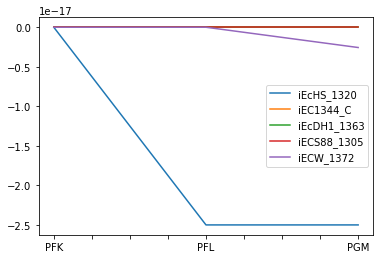

In [ ]:
obj_df.plot()

#Question: best way to represent data in graph form to illustate knockout differences?
#Question convert the Bigg Model to a networkx graph to do more networky types of experiments?
#https://gitter.im/opencobra/cobrapy?at=5d223634631d3433ba416891

<h3> Notes </h3>

rxn_ids = ['PFK', 'PFL', 'PGM', 'PYRt2' ,'PGL', 'PPS', 'EX_ac_e', 'DM_amob_c']

- Best way to represent data in graph form to illustate knockout differences?
    What am I trying to say? What is the goal?

- Convert the Bigg Model to a networkx graph to do more networky types of experiments?

- Any way to undo knock outs? Seems to be affecting the model even after restarting.
    Consider targeting parts of the metabolic network. As a function of the network statistics. Knockout highest degree. Clustering Coefficient. Centrality Measurements. 
    Degree is a bad way to kill Ecoli. What is most effective piece of network to target. Don't use ER graph. 

    parse text of output metabolites. Can turn it into a network.
    
Find out what is causing persistent state.


We want to maximize the objective function (Biomass for all Ecoli) by optimizing the model given that certain reactions are knocked out.

"Metabolic flux analysis of E. coli knockouts: lessons from the Keio collection and future outlook":

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5842030/

__Notes as of 11/30__:

Found an interesting paper that edits an E. coli SBML to make a P3HB pathway (a biodegradable plastic found in other bacteria). They were able to increase the output of P3HB using the objective function an changing the medium/knocking out certain pathways. Unfortunately they don't seem to include any code at all... https://www.sciencedirect.com/science/article/pii/S0141022917301308?casa_token=-FJiNOPOfFwAAAAA:G0jBhswsFmLC9sVtCHs0rFCk9Hrs3KgsTOn_QoaWouXPAsyA6QyhZ3JAi_qHeTLa5O72ZbgNLA 

Otherwise, couldn't find any papers since 2016 that look at network structure. 

- Did a few centrality measurements and found pretty much what was expected. Substrates like h_c have highest scores.
- Sorted the reactions by closeness centrality and it definitely wrecks the objective value.

-- Tell how data got out of model.
-- Summarize the structure.
-- What insights from summary statistics.
-- 2 Input and 1 Output node, find all shortest paths between them. 
-- What reactions affect what. Paths touch Kreb's Cycle? Describe structure of those flows.
-- Describe hypothesis of centralitity. Describe expirement What does it tell me about the structure of metabolic networks?
-- Lean heavy into the interpretation side of stuff. 

<h2> Changing growth media experiments:

In [ ]:
# with model: 
#     new_medium = model.medium
#     new_medium['EX_h2o_e'] = 0.01
#     model.medium = new_medium
#     print(model.slim_optimize())
#     print(model.medium)
# #model.medium

# medium = model.medium
# medium["EX_o2_e"] = 0.0
# model.medium = medium

# model.medium

In [ ]:
# def read_json_file(filename):
#     with open(filename) as f:
#         js_graph = json.load(f)
#     return nx.node_link_graph(js_graph)

# read_json_file('./data/iEcHS_1320.json')
#nx.read_gml('./data/iEC1344_C.xml')
# nx.read_graphml("./data/iEcHS_1320.xml")

In [ ]:
# import scipy as sc

# path = 'file.mat'

# raw_data = sc.loadmat(path, squeeze_me=True)

# data = raw_data['data_struct']